## Regressão simbólica aplicada ao modelo populacional de Gompertz

In [1]:
# Impot de bibliotecas 

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import gompertz, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)


pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	2.68812e+40	0  	3.38146	1000  	8.49632e+41	3.913	0  	2  	1000  	1.63567
1  	497   	5192.22    	1  	2.31984	497   	163596     	3.766	1  	1  	497   	1.59287
2  	518   	13.7217    	2  	2.31984	518   	20.6304    	3.651	2  	1  	518   	1.66469
3  	505   	8.06435e+40	3  	2.31984	505   	1.47013e+42	3.662	3  	1  	505   	1.70931
4  	553   	2.68812e+40	4  	2.31984	553   	8.49632e+41	3.858	4  	1  	553   	1.73143
5  	518   	5.37623e+40	5  	1.4593 	518   	1.20096e+42	4.099	5  	1  	518   	1.83172
6  	543   	9.58057    	6  	0.947205	543   	15.9336    	4.225	6  	1  	543   	1.74653
7  	539   	9.01009    	7  	0.947205	539   	13.2415    	4.261	7  	1  	539   	1.68193
8  	524   	1930.31    	8  	0.947205	524   	60

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\JupyterLab\meu-jupyter-ilum\3 semestre\Redes Neurais\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)


11 	522   	inf        	11 	0.947205	522   	nan        	5.176	11 	2  	522   	2.00275
12 	547   	inf        	12 	0.947205	547   	nan        	5.523	12 	2  	547   	2.21031
13 	561   	inf        	13 	0.947205	561   	nan        	6.004	13 	1  	561   	2.42363
14 	495   	inf        	14 	0.947205	495   	nan        	6.301	14 	1  	495   	2.56055
15 	468   	inf        	15 	0.947205	468   	nan        	6.425	15 	1  	468   	2.77135
16 	478   	inf        	16 	0.947205	478   	nan        	6.75 	16 	1  	478   	2.9444 


C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_6424/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


17 	547   	inf        	17 	0.947205	547   	nan        	6.774	17 	1  	547   	2.71605
18 	525   	inf        	18 	0.947205	525   	nan        	6.907	18 	1  	525   	2.6066 
19 	486   	inf        	19 	0.947205	486   	nan        	7.135	19 	2  	486   	2.52325
20 	522   	inf        	20 	0.947205	522   	nan        	7.174	20 	1  	522   	2.34088
21 	462   	inf        	21 	0.947205	462   	nan        	7.26 	21 	1  	462   	2.12847
22 	476   	inf        	22 	0.947205	476   	nan        	7.202	22 	1  	476   	1.8339 
23 	482   	inf        	23 	0.947205	482   	nan        	7.143	23 	1  	482   	1.57371
24 	498   	inf        	24 	0.947205	498   	nan        	7.134	24 	1  	498   	1.59187
25 	512   	inf        	25 	0.947205	512   	nan        	7.146	25 	1  	512   	1.66213
26 	551   	inf        	26 	0.947205	551   	nan        	7.134	26 	1  	551   	1.61804
27 	513   	inf        	27 	0.947205	513   	nan        	7.109	27 	1  	513   	1.64412
28 	550   	inf        	28 	0.947205	550   	nan        	7.182	28 	2  	550   	

In [11]:
for i in hof.items:
    print(str(i))
    print()

add(Exp(sub(add(t, 1), Exp(1))), Exp(sub(1, t)))

add(Exp(sub(add(1, t), Exp(1))), Exp(sub(1, t)))

add(Exp(sub(1, t)), Exp(sub(sub(t, -1), Exp(1))))

add(Exp(sub(1, t)), Exp(sub(add(t, 1), Exp(1))))

add(Exp(sub(1, t)), Exp(sub(add(1, t), Exp(1))))



### Reportando o melhor individuo encontrado

add(Exp(sub(add(t, 1), Exp(1))), Exp(sub(1, t)))


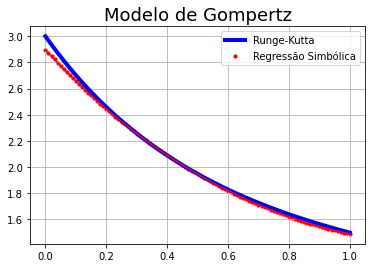

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', c = 'r', s = 10)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

E*exp(-E)*exp(t) + E*exp(-t)